In [37]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd

In [142]:
conf = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
conf = conf.sort_values(conf.columns[-1], ascending=False)
conf.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
154,Hubei,China,30.9756,112.2707,444,444,549,761,1058,1423,...,67786,67790,67794,67798,67799,67800,67800,67800,67800,67800
16,NaN,Italy,43.0000,12.0000,0,0,0,0,0,0,...,17660,21157,24747,27980,31506,35713,41035,47021,53578,59138
18,NaN,Spain,40.0000,-4.0000,0,0,0,0,0,0,...,5232,6391,7798,9942,11748,13910,17963,20410,25374,28768
11,NaN,Germany,51.0000,9.0000,0,0,0,0,0,1,...,3675,4585,5795,7272,9257,12327,15320,19848,22213,24873
155,NaN,Iran,32.0000,53.0000,0,0,0,0,0,0,...,11364,12729,13938,14991,16169,17361,18407,19644,20610,21638
157,France,France,46.2276,2.2137,0,0,2,3,3,3,...,3661,4469,4499,6633,7652,9043,10871,12612,14282,16018
99,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,421,525,732,967,1706,2495,5365,8310,11710,15793
156,NaN,"Korea, South",36.0000,128.0000,1,1,2,2,3,4,...,7979,8086,8162,8236,8320,8413,8565,8652,8799,8897
31,NaN,Switzerland,46.8182,8.2275,0,0,0,0,0,0,...,1139,1359,2200,2200,2700,3028,4075,5294,6575,7245
403,United Kingdom,United Kingdom,55.3781,-3.4360,0,0,0,0,0,0,...,798,1140,1140,1543,1950,2626,2689,3983,5018,5683


In [ ]:
for c in list(conf['Country/Region'].unique()):
    print(c)

In [267]:
# Combine rows that correspond to the same country but different state/province

conf = pd.read_csv('./csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
conf = conf.sort_values(conf.columns[-1], ascending=False)
conf.drop(columns=['Province/State'], inplace=True)
cols = list(conf.columns.values)
vals = []
dates = []
for col in cols:
    if col[0].isdigit():
        dates.append(col)
        vals.append('sum')
    else:
        vals.append('first')
agg = dict(zip(cols, vals))
conf_combined = conf.groupby(conf['Country/Region']).aggregate(agg)
conf_combined = conf_combined.sort_values(conf.columns[-1], ascending=False)

In [247]:
"""Normalized growth rate

Parameters
----------
arr : float
    1D array of data
dx : float
    spacing beween data points
padding : string
    type of padding for boundaries
    Options: 'Same', 'Zero', 'Reflect
    
Returns 
-------
float
    1D array of growth rates'"""
def growth(arr, dx, padding='Same'):
    d = [None] * len(arr)
    for i in range(1, len(arr)-1):
        d[i] = (arr[i] - arr[i-1]) / dx
    if padding is 'Same':
        d[0] = d[1]
        d[-1] = d[-2]
    elif padding is 'Zero':
        d[0] = 0
        d[-1] = 0
    else:
        d[0] = d[-1]
        d[-1] = d[0]
    return d

"""2nd derivative finite difference (https://en.wikipedia.org/wiki/Five-point_stencil)

Parameters
----------
arr : float
    1D array of data
dx : float
    spacing between data points (must be constant)
padding : string
    type of padding for boundaries
    Options: 'Same', 'Zero', 'Reflect'
stencil_size : int
    size of stencil
    Option: 3, 5
    
Returns
-------
float
    1D array of finite differences
"""
def fd_2(arr, dx, padding='Same', stencil_size=3):
    d = [None] * len(arr)
    if stencil_size is 3:
        for i in range(1, len(arr)-1):
            d[i] = (arr[i-1] - 2*arr[i] + arr[i+1]) / dx
    elif stencil_size is 5:
        d[1] = (arr[0] - 2*arr[1] + arr[2]) / dx
        d[-2] = (arr[-3] - 2*arr[-2] + arr[-1]) / dx
        for i in range(2, len(arr) - 2):
            d[i] = (-arr[i-2] + 16*arr[i-1] - 30*arr[i] + 16*arr[i+1] - arr[i+2]) / 12

    if padding is 'Same':
        d[0] = d[1]
        d[-1] = d[-2]
    elif padding is 'Zero':
        d[0] = 0
        d[-1] = 0
    else:
        d[0] = d[-1]
        d[-1] = d[0]
    return d

In [248]:
def plotn(dates, df, delta_x, num_countries=1, date_range=[0,-1], mode='num_cases'):
    plt.figure()
    df_T = df.T
    x = [dt.datetime.strptime(d, '%m/%d/%y').date() for d in dates]
    legend = df['Country/Region']
    dr = date_range
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    if mode is 'num_cases':
        for i in range(num_countries):
            plt.plot(x[dr[0]:dr[1]], df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0).iloc[dr[0]:dr[1],i], label=legend[i])
    elif mode is 'growth':
        for i in range(num_countries):
            g = growth(list(conf_T.drop(['Country/Region', 'Lat', 'Long'], axis=0).iloc[:,i]), delta_x, 'Same')
            plt.plot(x[dr[0]:dr[1]], g[dr[0]:dr[1]], label=legend[i])
    elif mode is 'deriv2':
        for i in range(num_countries):
            d = fd_2(list(conf_T.drop(['Country/Region', 'Lat', 'Long'], axis=0).iloc[:,i]), delta_x, 'Same')
            plt.plot(x[dr[0]:dr[1]], d[dr[0]:dr[1]], label=legend[i])
    plt.legend()
    plt.gcf().autofmt_xdate()
    
def plotc(dates, df, delta_x, countries=['US'], date_range=[0,-1], mode='num_cases'):
    plt.figure()
    df_T = df.T
    x = [dt.datetime.strptime(d, '%m/%d/%y').date() for d in dates]
    dr = date_range
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    if mode is 'num_cases':
        for c in countries:
            plt.plot(x[dr[0]:dr[1]], df_T.drop(['Country/Region', 'Lat', 'Long'], axis=0)[c][dr[0]:dr[1]], label=c)
    elif mode is 'growth':
        for c in countries:
            g = growth(list(conf_T.drop(['Country/Region', 'Lat', 'Long'], axis=0)[c]), delta_x, 'Same')
            plt.plot(x[dr[0]:dr[1]], g[dr[0]:dr[1]], label=c)
    elif mode is 'deriv2':
        for c in countries:
            d = fd_2(list(conf_T.drop(['Country/Region', 'Lat', 'Long'], axis=0)[c]), delta_x, 'Same', 3)
            plt.plot(x[dr[0]:dr[1]], d[dr[0]:dr[1]], label=c)
    plt.legend()
    plt.gcf().autofmt_xdate()

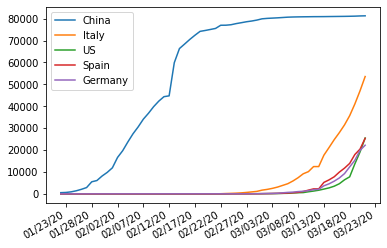

In [249]:
plotn(dates, conf_combined, 1, 5, mode='num_cases')

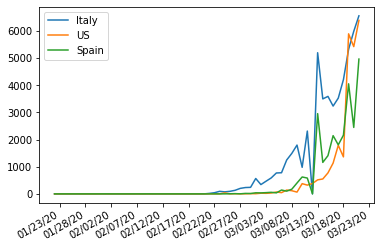

In [250]:
plotc(dates, conf_combined, 1, countries=['Italy', 'US', 'Spain', ], mode='growth')